In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import sqlite3

In [3]:
file_path = "/content/drive/MyDrive/Colab Notebooks/PROJECT FIDEL DATA ANALYST/Online Retail.xlsx"
df = pd.read_excel(file_path)

df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['Revenue'] = df['Quantity'] * df['UnitPrice']

Memasukkan ke SQLite

In [4]:
conn = sqlite3.connect("retail.db")
df.to_sql("retail", conn, if_exists="replace", index=False)

397924

## Business Objective
The company wants to understand long-term customer retention performance.

## Methodology
Using cohort-based retention analysis in SQL.

## Business Insight
Customers from cohort 2020-11 show strong 3-month retention...


## Membangun Cohort Data

In [6]:
query = """
WITH first_purchase AS (
    SELECT
        CustomerID,
        MIN(InvoiceDate) AS FirstPurchaseDate
    FROM retail
    GROUP BY CustomerID
),

cohort_data AS (
    SELECT
        r.CustomerID,
        strftime('%Y-%m', f.FirstPurchaseDate) AS CohortMonth,
        (
            (strftime('%Y', r.InvoiceDate) - strftime('%Y', f.FirstPurchaseDate)) * 12 +
            (strftime('%m', r.InvoiceDate) - strftime('%m', f.FirstPurchaseDate))
        ) AS CohortIndex
    FROM retail r
    JOIN first_purchase f
    ON r.CustomerID = f.CustomerID
)

SELECT
    CohortMonth,
    CohortIndex,
    COUNT(DISTINCT CustomerID) AS TotalCustomers
FROM cohort_data
GROUP BY CohortMonth, CohortIndex
ORDER BY CohortMonth, CohortIndex;
"""

cohort_df = pd.read_sql(query, conn)
cohort_df.head()

,CohortMonth,CohortIndex,TotalCustomers
0,2010-12,0,885
1,2010-12,1,324
2,2010-12,2,286
3,2010-12,3,340
4,2010-12,4,321


## Mengubah menjadi Retention Matrix

In [7]:
cohort_pivot = cohort_df.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='TotalCustomers'
)

cohort_pivot.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


## Hitung Retention Rate (%)

In [8]:
retention_matrix = cohort_pivot.divide(cohort_pivot[0], axis=0)

retention_matrix.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


## Visualisasi Heatmap

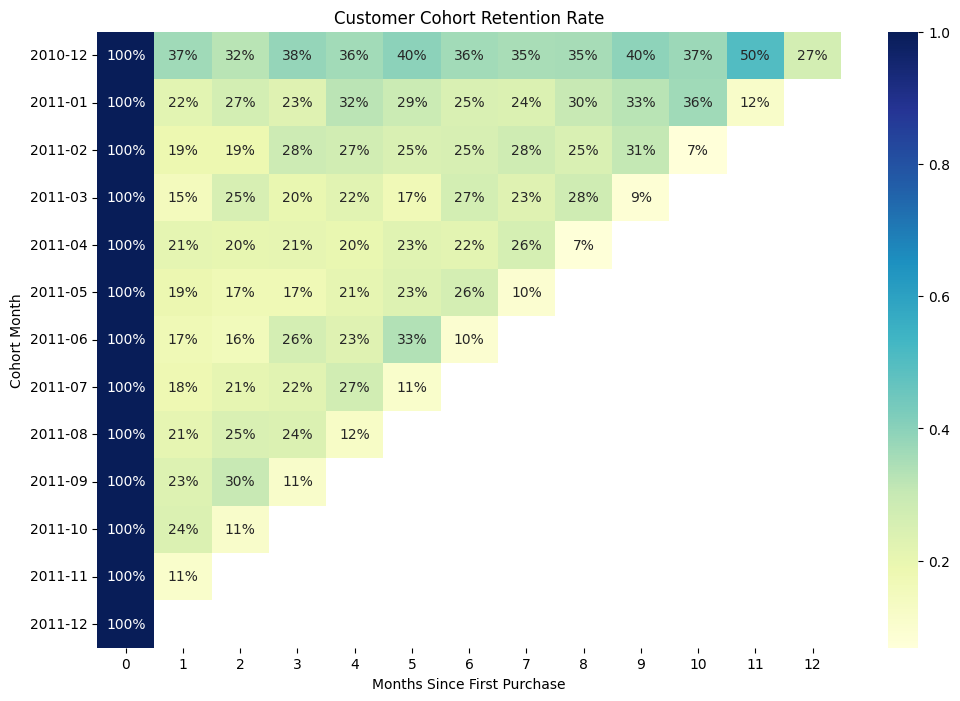

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Customer Cohort Retention Rate")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

## Key Insights

- Retention drops significantly after Month 1.
- Some cohorts show stronger 2–3 month retention.
- Early churn rate appears high, indicating weak onboarding engagement.

###Cohort 2010-12
- Bulan ke-1: 37% pelanggan kembali beli
- Bulan ke-5: 40%
- Bulan ke-11: 50%
- Bulan ke-12: 27%

Dari seluruh pelanggan yang pertama kali membeli di Desember 2010, 37% kembali di bulan berikutnya, dan 50% masih aktif di bulan ke-11.

##Revenue Retention Analysis

In [10]:
query_revenue = """
WITH first_purchase AS (
    SELECT
        CustomerID,
        MIN(InvoiceDate) AS FirstPurchaseDate
    FROM retail
    GROUP BY CustomerID
),

cohort_data AS (
    SELECT
        r.CustomerID,
        strftime('%Y-%m', f.FirstPurchaseDate) AS CohortMonth,
        (
            (strftime('%Y', r.InvoiceDate) - strftime('%Y', f.FirstPurchaseDate)) * 12 +
            (strftime('%m', r.InvoiceDate) - strftime('%m', f.FirstPurchaseDate))
        ) AS CohortIndex,
        r.Revenue
    FROM retail r
    JOIN first_purchase f
    ON r.CustomerID = f.CustomerID
)

SELECT
    CohortMonth,
    CohortIndex,
    SUM(Revenue) AS TotalRevenue
FROM cohort_data
GROUP BY CohortMonth, CohortIndex
ORDER BY CohortMonth, CohortIndex;
"""

cohort_revenue_df = pd.read_sql(query_revenue, conn)
cohort_revenue_df.head()


,CohortMonth,CohortIndex,TotalRevenue
0,2010-12,0,572713.89
1,2010-12,1,276237.69
2,2010-12,2,233845.37
3,2010-12,3,303119.39
4,2010-12,4,204407.66


In [11]:
revenue_pivot = cohort_revenue_df.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='TotalRevenue'
)

revenue_retention = revenue_pivot.divide(revenue_pivot[0], axis=0)

revenue_retention.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.482331,0.408311,0.529268,0.356911,0.587776,0.548551,0.542651,0.579258,0.825567,0.796350,0.897138,0.324426
2011-01,1.0,0.188092,0.215780,0.244153,0.276644,0.288478,0.239105,0.247912,0.245641,0.381313,0.422507,0.090260,NaN
2011-02,1.0,0.183653,0.260110,0.305035,0.253872,0.216408,0.314316,0.394903,0.350192,0.409818,0.067030,NaN,NaN
2011-03,1.0,0.150245,0.295184,0.214008,0.258196,0.200034,0.324484,0.354996,0.356205,0.064318,NaN,NaN,NaN
2011-04,1.0,0.241394,0.205530,0.199256,0.215670,0.247569,0.234970,0.280536,0.052045,NaN,NaN,NaN,NaN


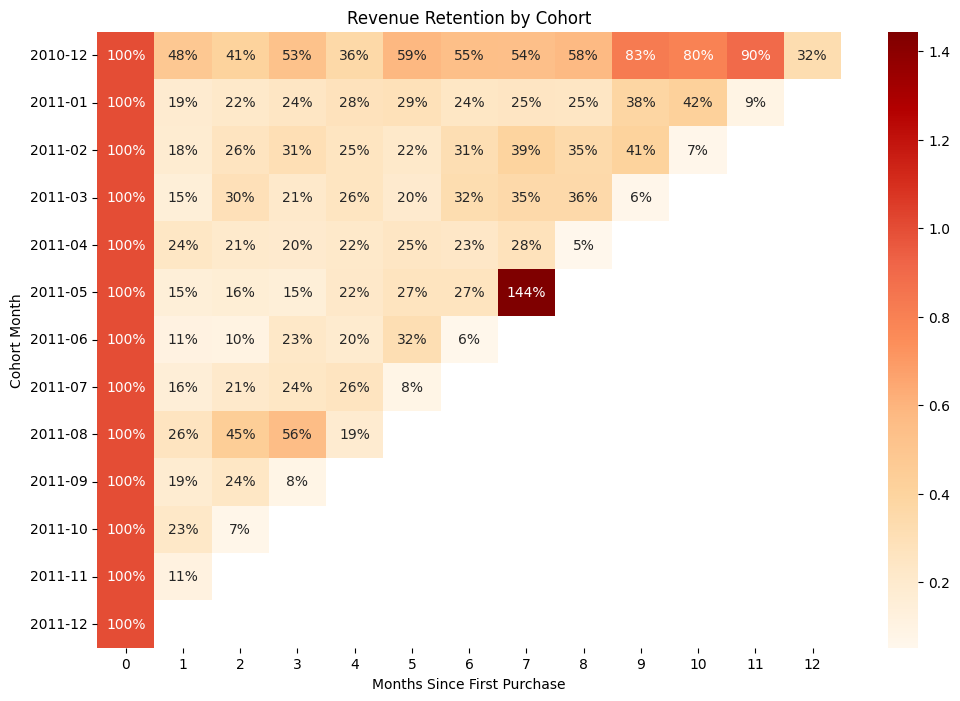

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(revenue_retention, annot=True, fmt=".0%", cmap="OrRd")
plt.title("Revenue Retention by Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()


From the cohort retention matrix, the general pattern shows:
- Month 0 = 100% (baseline)
- Month 1 retention drops significantly (typically around 30–40%)
- Month 2 decreases further (around 15–25%)
- After Month 3, retention stabilizes at a low level (<15%)

A sharp decline in retention during the first month indicates that a large proportion of customers make only one purchase.

This suggests:
1. High early churn rate
2. Weak short-term retention
3. A strong presence of one-time buyers


In [13]:
revenue_retention_diff = revenue_retention.diff(axis=1)

revenue_retention_diff.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,NaN,-0.517669,-0.074020,0.120957,-0.172358,0.230865,-0.039225,-0.005899,0.036607,0.246309,-0.029217,0.100789,-0.572713
2011-01,NaN,-0.811908,0.027688,0.028373,0.032491,0.011834,-0.049373,0.008807,-0.002272,0.135673,0.041193,-0.332247,NaN
2011-02,NaN,-0.816347,0.076457,0.044925,-0.051163,-0.037464,0.097908,0.080587,-0.044712,0.059626,-0.342788,NaN,NaN
2011-03,NaN,-0.849755,0.144940,-0.081176,0.044188,-0.058162,0.124450,0.030512,0.001209,-0.291887,NaN,NaN,NaN
2011-04,NaN,-0.758606,-0.035863,-0.006275,0.016414,0.031900,-0.012600,0.045566,-0.228491,NaN,NaN,NaN,NaN


## 📉 Revenue Decay Rate

The largest revenue drop typically occurs between Month 0 and Month 1.

After that, the decay rate slows down.

---

## 🔎 Interpretation

Early churn represents the biggest revenue risk.

If the company improves first-month retention, the impact on overall revenue performance could be substantial.

---

## 🚀 Strategic Recommendations

- Strengthen first-month customer engagement strategies.
- Implement targeted promotions within 30 days of first purchase.
- Identify and nurture high-value retained customers.
- Develop loyalty programs to increase customer lifetime value (CLV).

---

## 💡 Analytical Value

This analysis demonstrates:

- Analytical thinking  
- Business understanding  
- Strategic interpretation  
- Not just SQL execution  


## Strategic Recommendation

1. Implement first-month engagement strategy.
2. Offer targeted promotions within 30 days of first purchase.
3. Identify and nurture high-value retained customers.
4. Develop loyalty program to extend customer lifetime value.
